In [83]:
from helpers import helper_functions
import time
import os

import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import yaml

In [88]:
#root_dir='/global/cscratch1/sd/abbatej/autoruns/no_smoothing/numlayers_0_densact_linear_denssize_20'
root_dir='/global/homes/a/abbatej/plasma-profile-predictor/'
#root_dir='/global/cscratch1/sd/abbatej/autoruns/delay_with_0d_lookahead_2/ncomponents_None_delay_3_prelayers_2_size_20_rnnsize_20_'
input_dir='/global/cscratch1/sd/abbatej/data'
model_filename='model.h5'
#model_filename='gru_cnn_renormed_40.h5'

def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config

config=load_config(os.path.join('/global/homes/a/abbatej/plasma-profile-predictor/configs','lstm_cnn_merge_joe.yaml'))['data']

/usr/common/software/tensorflow/intel-tensorflow/1.13.1-py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [11]:
# RUN ONLY IF YOU NEED TO UPDATE THE DATA, TIMES, ETC
# helper_functions.preprocess_data(dirname=config['input_dir_name'], 
#                                     sigs_0d=config['sigs_0d'],
#                                     sigs_1d=config['sigs_1d'],
#                                     sigs_predict=config['sigs_predict'],
#                                     n_components=config['n_components'],
#                                     avg_window=config['avg_window'],
#                                     lookback=config['lookback'],
#                                     delay=config['delay'],
#                                     train_frac=config['train_frac'],
#                                     val_frac=config['val_frac'],
#                                     save_data=True)

Loading data: 0.20137643814086914s
Creating shot list (check whether data contains necessary sigs - loop over shots): 0.0002865791320800781s
Dumping data into new dictionary from data dictionary (loop over shots, sigs): 0.03219747543334961s
Removed 0 shots with empty arrays
Getting means and stds: 0.05919957160949707s
Number of timesteps in data:
 212
Putting training data into right shape: 8.33852505683899s
Number of timesteps in data:
 271
Putting training data into right shape: 1.858513593673706s
saving data to /global/homes/a/abbatej/...
data saved to /global/homes/a/abbatej/


In [89]:
rho_points=np.linspace(0,1,65)

In [90]:
#sig_names = ['Target current (A)', 'Injected power (kW)', 'Injected torque (Nm)']#, 'Gas A']
sig_keys_0d = config['sigs_0d']
sig_keys_1d = config['sigs_1d']
#sig_keys = ['curr_target', 'pinj', 'tinj'] #['curr_target', 'pinj', 'tinj']

In [91]:
# matplotlib setup
%matplotlib inline

In [93]:
train_data = helper_functions.load_obj(os.path.join(input_dir,'train_data'))
train_target = helper_functions.load_obj(os.path.join(input_dir,'train_target'))
val_data = helper_functions.load_obj(os.path.join(input_dir,'val_data'))
val_target = helper_functions.load_obj(os.path.join(input_dir,'val_target'))

In [94]:
train_shot = helper_functions.load_obj(os.path.join(input_dir,'train_shot'))
val_shot = helper_functions.load_obj(os.path.join(input_dir,'val_shot'))
train_time = np.array(helper_functions.load_obj(os.path.join(input_dir,'train_time')))
val_time = np.array(helper_functions.load_obj(os.path.join(input_dir,'val_time')))

In [95]:
means = helper_functions.load_obj(os.path.join(input_dir,'means'))
stds = helper_functions.load_obj(os.path.join(input_dir,'stds'))

In [96]:
print('Means: ', means)
print('Stds: ', stds)

Means:  {'curr': 785132.5847824349, 'pinj': 4131.516461794492, 'temp': array([2.60443354, 2.60261081, 2.597802  , 2.58969949, 2.57865537,
       2.56469577, 2.54786642, 2.52848363, 2.50633042, 2.48190785,
       2.45496111, 2.42590588, 2.39468459, 2.36147504, 2.32643621,
       2.28955464, 2.25115953, 2.21109241, 2.16973963, 2.12704294,
       2.08322386, 2.03836603, 1.99257346, 1.94602416, 1.89875061,
       1.8509659 , 1.80271198, 1.75416179, 1.70540491, 1.65656886,
       1.60776073, 1.55910721, 1.51068689, 1.46266841, 1.4150869 ,
       1.36810544, 1.32178125, 1.2762207 , 1.23154069, 1.18775116,
       1.14506064, 1.10337756, 1.06293721, 1.02364473, 0.98563444,
       0.94890605, 0.91344115, 0.87933839, 0.84641425, 0.81484795,
       0.78434727, 0.75494028, 0.7263488 , 0.69829956, 0.67019198,
       0.64114039, 0.60907458, 0.5716421 , 0.52201053, 0.45192633,
       0.34924439, 0.22728132, 0.12503124, 0.06612065, 0.03521096]), 'thomson_dens': array([4.89921147e+19, 4.96506283e+19, 4

In [27]:
# if config['n_components']!='None':
#     pca = helper_functions.load_obj(input_dir+'pca')

In [97]:
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')

In [98]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 132)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 16, 20)            2660      
_________________________________________________________________
dense_2 (Dense)              (None, 16, 20)            420       
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                9760      
_________________________________________________________________
dense_3 (Dense)              (None, 65)                2665      
Total params: 15,505
Trainable params: 15,505
Non-trainable params: 0
_________________________________________________________________


In [99]:
input_data=val_data
output_data=val_target

In [69]:
# Get ML model performance for full
val_mae = abs(loaded_model.predict(input_data)-output_data)

# Compared to having signals zeroed out
if len(sig_keys_0d)>0:
    input_data_zeroed=np.copy(input_data)
    input_data_zeroed[:,:,:len(sig_keys_0d)]=0
    val_mae_holdout = abs(loaded_model.predict(input_data_zeroed)-output_data)
    
# ML performance for just rampup
val_mae = abs(loaded_model.predict(input_data[rampup_timesteps,:,:])-output_data[rampup_timesteps,:])

In [70]:
avg_val_mae=np.mean(val_mae, axis=0)
std_val_mae=np.std(val_mae, axis=0)
avg_val_mae_holdout=np.mean(val_mae_holdout, axis=0)
std_val_mae_holdout=np.std(val_mae_holdout, axis=0)

In [71]:
# Get performance based on simply guessing the previous timestep
#np.diff(input_data[:,-1,num_sigs:],axis=0)
#baseline_mae=abs(np.diff(input_data[:,-1,num_sigs:],axis=0))

# for full
baseline_mae=abs(output_data)

# for just rampup
baseline_mae=abs(output_data[rampup_timesteps,:])

In [72]:
avg_baseline_mae=np.mean(baseline_mae, axis=0)
std_baseline_mae=np.std(baseline_mae, axis=0)

In [73]:
print('{0:.5f}'.format(np.mean(avg_baseline_mae)))
print('{0:.5f}'.format(np.mean(avg_val_mae)))

0.08672
0.11262


In [74]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_timestep(timestep, train=False, normalized=True, 
                  sig_to_perturb=None):
    
    delay = config['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['temp'])+means['temp']
        true_real = np.multiply(true,stds['temp'])+means['temp']
        prev_real = (np.multiply(prev,stds['thomson_temp'])+means['thomson_temp'])/1000.
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if sig_to_perturb is not None:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])

        input_data_perturbed=input_data.copy()


        # Flatline at the previous value
        input_data_perturbed[:,:,sig_index]=input_data_perturbed[:,0,sig_index]
        # Increase linearly
        #input_data_perturbed[:,:,sig_index]*=[1+i*.1 for i in range(input_data_perturbed.shape[1])]
        # add 10%
        #input_data_perturbed[:,:,sig_index] *= 1.1



        pred_perturbed=np.ndarray.flatten(loaded_model.predict(input_data_perturbed))
        if normalized:
            pred_perturbed_real=pred_perturbed
        else: 
            if config['n_components']!='None':
                # do the processing with pca, which was already loaded
                pred_perturbed = pca.inverse_transform(pred_perturbed)
            pred_perturbed_real = np.multiply(pred_perturbed,stds['e_temp'])+means['e_temp']
        ax.plot(rho_points,pred_perturbed_real,
                label='Predicted with perturbation to {}'.format(sig_to_perturb), 
                linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    if normalized:
        ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    else:
        ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
            if sig_to_perturb is not None:
                if (i==sig_index):
                    ax.plot(true_times[timestep-config['lookback']:timestep+config['delay']+1],
                        input_data_perturbed[0,:,i],
                        linewidth=10)
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            if config['n_components']!='None':
                # do the processing with pca, which was already loaded
                tmp = pca.inverse_transform(tmp)
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [75]:
plt.rcParams['figure.figsize'] = [20, 15]
font={'size': 20, 'weight': 'heavy'}
plt.rc('font', **font)

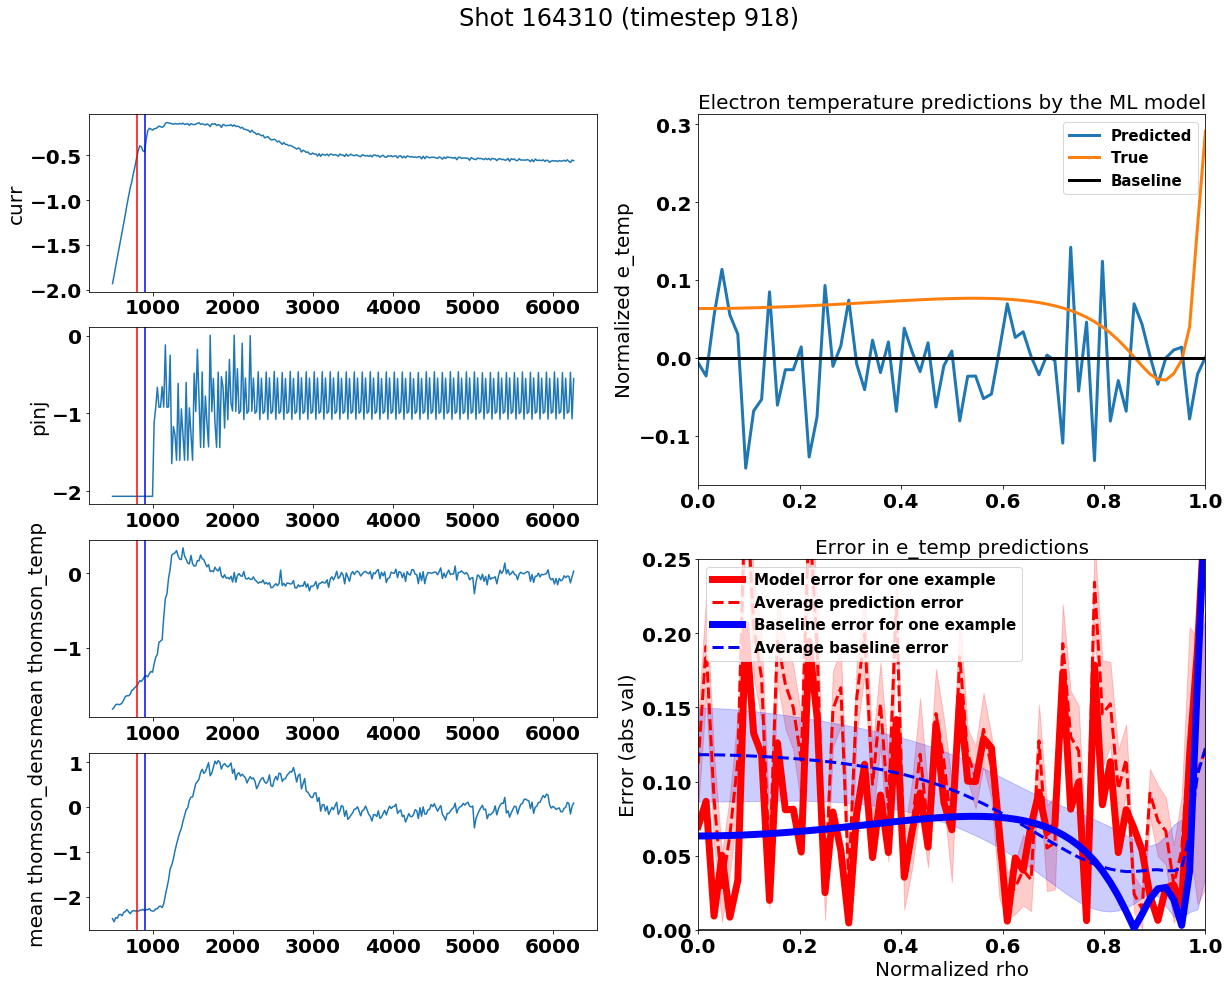

In [82]:
import random
random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds[:-1])+np.random.randint(10)

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i
#timestep=val_shot_inds[42]+20
timestep=918
plot_timestep(timestep, train=False, normalized=True, sig_to_perturb=None)

In [30]:
def plot_timestep_creative(timestep, train=False, normalized=True, 
                  perturbations=[], sig_to_perturb='pinj'):
    
    delay = config['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if len(perturbations)>0:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])
        for perturbation in perturbations:
            input_data_no_actuators=input_data.copy()
            input_data_no_actuators[:,:,sig_index]+=perturbation
            pred_no_actuators=np.ndarray.flatten(loaded_model.predict(input_data_no_actuators))

            if normalized:
                pred_no_actuators_real=pred_no_actuators
            else: 
                pred_no_actuators_real = np.multiply(pred_no_actuators,stds['e_temp'])+means['e_temp']

            ax.plot(rho_points,pred_no_actuators_real,
                    label='Predicted with {} additional std to {}'.format(perturbation, sig_to_perturb), 
                    linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            if config['n_components'] is not None:
                # do the processing with pca, which was already loaded
                pass
            print(sigs_all_times.shape)
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [235]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_presentation_ready(timestep, train=False, normalized=True, 
                  sig_to_perturb='pinj'):
    
    titlesize=50
    othersize=50
    legendsize=30
    linewidth=15
    smalllinewidth=10
    
    delay = config['delay']
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    plt.plot(rho_points,pred_real,label='Model Prediction at t+1', linewidth=smalllinewidth,c='r')
    
    plt.plot(rho_points,true_real,label='True Profile at t+1', linewidth=linewidth,c='b',linestyle=':')
    #for differences
    plt.plot(rho_points, prev_real,label='Profile at t',linewidth=linewidth, color='k')
     
    #### FOR SENSITIVITY ANALYSIS ####
#     words_for_multipliers=['increasing', 'fixed', 'decreasing']
#     colors=['g','y','r']
#     multipliers=[1,0,-1]
#     for i in range(len(multipliers)):
#         multiplier=multipliers[i]
#         this_sig_index=sig_keys_0d.index(sig_to_perturb)
#         other_sig_indices=range(len(sig_keys_0d),input_data.shape[2])

#         input_data_perturbed=input_data.copy()

#         # Flatline at the previous value for other signals
#         input_data_perturbed[:,-delay:,other_sig_indices]=input_data_perturbed[:,-delay-1,other_sig_indices]
#         # Increase linearly for the supplied signal
#         input_data_perturbed[:,-delay:,this_sig_index]*=[1+(i+1)*multiplier for i in range(delay)]
#         # add 10%
#         #input_data_perturbed[:,:,sig_index] *= 1.1

#         pred_perturbed=np.ndarray.flatten(loaded_model.predict(input_data_perturbed))
#         if normalized:
#             pred_perturbed_real=pred_perturbed
#         else: 
#             if config['n_components'] is not None:
#                 # do the processing with pca, which was already loaded
#                 pred_perturbed = pca.inverse_transform(pred_perturbed)
#             pred_perturbed_real = np.multiply(pred_perturbed,stds['e_temp'])+means['e_temp']
#         plt.plot(rho_points,pred_perturbed_real,
#                 label='t+1 prediction, {} {}'.format(sig_to_perturb, words_for_multipliers[i]), 
#                 linestyle='--',
#                 color=colors[i],
#                 linewidth=smalllinewidth)
    ##################################
    
    #plt.title('Electron temperature profile prediction', fontsize=titlesize)    
    plt.ylabel('Electron temperature (keV)', fontsize=othersize)
    plt.xlabel('Spatial position (normalized)', fontsize=othersize)
    plt.xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    plt.legend(loc='best', fontsize=legendsize)
    
    print('Shot {}\nt={:0.0f} ms\nt+1={:0.0f} ms'.format(shot_num,true_times[timestep],true_times[timestep+delay]))
    plt.show()

1419
Shot 163172
t=676 ms
t+1=736 ms


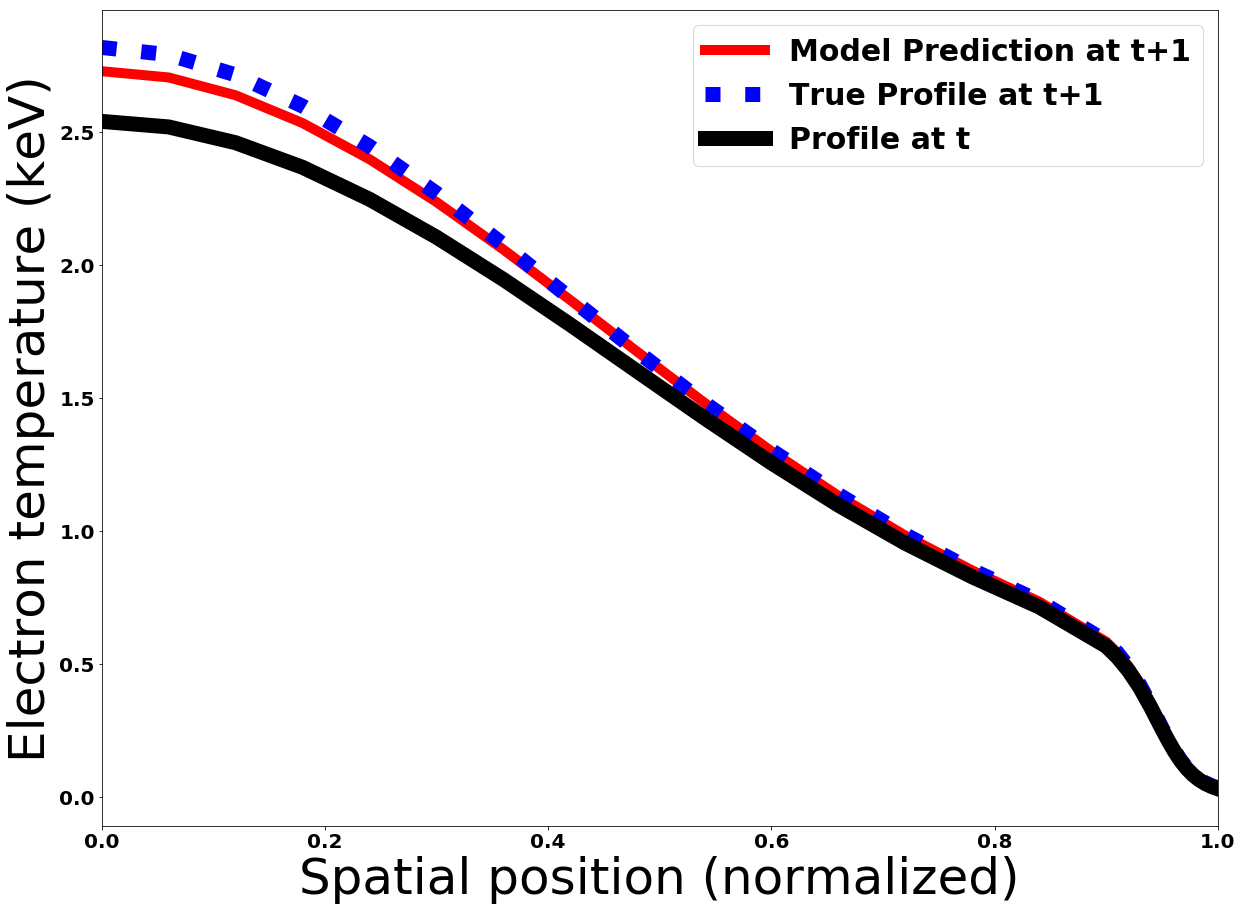

In [236]:
import random
random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds)+np.random.randint(10)

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i

timestep=1419
print(timestep)
plot_presentation_ready(timestep, train=False, normalized=False, sig_to_perturb='pinj')

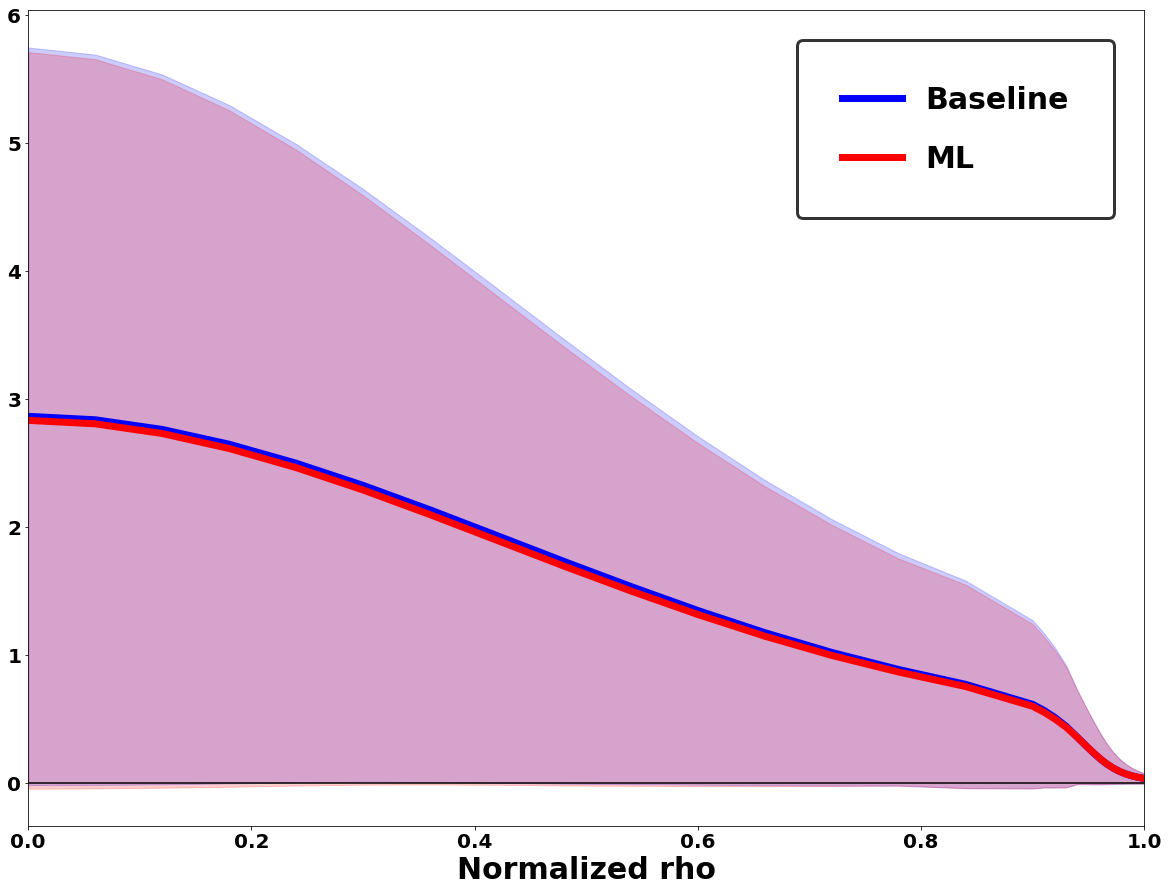

In [267]:
# plt.plot(rho_points,avg_val_mae, c='r', alpha=.5)
# plt.plot(rho_points, avg_baseline_mae, c='b', alpha=.5)

baseline_real=np.multiply(avg_baseline_mae,stds['e_temp'])+means['e_temp']
baseline_std_real=np.multiply(std_baseline_mae,stds['e_temp'])+means['e_temp']
ml_real=np.multiply(avg_val_mae,stds['e_temp'])+means['e_temp']
ml_std_real=np.multiply(std_val_mae,stds['e_temp'])+means['e_temp']

plt.fill_between(rho_points, baseline_real - baseline_std_real, baseline_real + baseline_std_real, color='b', alpha=0.2)
plt.fill_between(rho_points, ml_real - ml_std_real, ml_real + ml_std_real, color='r', alpha=0.2)

#plt.plot(rho_points, avg_baseline_reg_mae, c='k', label='Baseline Linear Regression', linewidth=7.0)
plt.plot(rho_points, baseline_real, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,ml_real, c='r', label='ML', linewidth=7.0)
# plt.plot(rho_points,avg_val_mae_holdout, c='b', label='ML no actuators', linewidth=7.0)
# plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
# plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
#plt.title('Comparing prediction error with and without rho=30', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
#plt.ylabel('(Model with rho=30) - (Model without rho=30)', fontweight='heavy', fontsize=30)
plt.axhline(0,c='k')
plt.xlim(0,1.0)
plt.show()